In [69]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import tensorflow as tf

In [2]:
import datetime
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers 
from keras.layers import Input
from keras import layers
from keras.models import Model

ModuleNotFoundError: No module named 'keras'

#### Import data and convert time into index

In [3]:
df = pd.read_csv("../data/train.csv")

NameError: name 'pd' is not defined

In [561]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df.head()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
Date,,,,,,,,,,,,,
2020-04-12,0,Alabama,2020-04-12,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945
2020-04-12,1,Alaska,2020-04-12,272,8,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059
2020-04-12,2,Arizona,2020-04-12,3542,115,NaN,3427.0,48.662422,42109.0,NaN,3.246753,578.522286,NaN
2020-04-12,3,Arkansas,2020-04-12,1280,27,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250
2020-04-12,4,California,2020-04-12,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,2.812020,485.423869,22.961176


In [562]:
df_1 = df[['Province_State','Confirmed', 'Deaths']]

#### Impute missing values

In [563]:
def impute_first_nan(data):
    for i in range(len(data.columns)):
        if data.columns[i] == 'Province_State':
            continue
        else:
            if np.isnan(data.iloc[0,i]):
                data.iloc[0,i] = 0

def impute_missing_vals(data):
    impute_first_nan(data)
    for col in data.columns:
        if col == 'Province_State':
            continue
        else:
            if sum(np.isnan(data[col])) != 0:
                data[col] = data[col].interpolate(method='linear')
    return data

In [564]:
df_impute = pd.DataFrame()
for p in np.unique(df_1['Province_State']):
    if len(df_impute) == 0:
        df_impute = impute_missing_vals(df_1[df_1['Province_State'] == p])
    else:
        df_impute = df_impute.append(impute_missing_vals(df_1[df_1['Province_State'] == p]))

#### Calculate daily increase to replace cumulative

In [565]:
df_1b = df_impute.copy()
df_1b = df_1b.drop([datetime.datetime.strptime('2020-04-12','%Y-%m-%d')])
for p in np.unique(df_1['Province_State']):
    for col in ['Confirmed', 'Deaths']:
        df_1b.loc[df_1b['Province_State'] == p, col] = np.diff(df_impute.loc[df_impute['Province_State'] == p, col])

#### Smoothing by taking rolling average

In [566]:
for p in np.unique(df_1['Province_State']):
    for col in ['Confirmed', 'Deaths']:
        df_temp = df_1b.loc[df_1b['Province_State'] == p]
        val = df_temp.loc[:, col].rolling(window=4, min_periods = 1, center=True).mean().values
        df_1b.loc[df_1b['Province_State'] == p, col] = val

#### Scaling

In [567]:
from sklearn.preprocessing import MinMaxScaler

scale each states independently

In [568]:
scaler_1_each = []
scaler_2_each = []
for i in range(1, len(df_1b.columns)):
    for p in np.unique(df_1['Province_State']):
        col = df_1b.columns[i]
        val = df_1b.loc[(df_1b['Province_State'] == p) &
                        (df_1b.index <= datetime.datetime.strptime('2020-08-31','%Y-%m-%d')) &
                        (df_1b.index >= datetime.datetime.strptime('2020-04-13','%Y-%m-%d')), col].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(val)
        scaled = scaler.transform(val)
        df_1b.loc[(df_1b['Province_State'] == p) &
                        (df_1b.index <= datetime.datetime.strptime('2020-08-31','%Y-%m-%d')) &
                        (df_1b.index >= datetime.datetime.strptime('2020-04-13','%Y-%m-%d')), col] = scaled
        if i == 1:
            scaler_1_each.append(scaler)
        elif i == 2:
            scaler_2_each.append(scaler)

#### Construct train and test set

In [569]:
n_input = 28
n_out = 7

In [570]:
def split_train_test(data):
    train = data.loc[(data.index <= datetime.datetime.strptime('2020-08-31','%Y-%m-%d')) &
                     (data.index >= datetime.datetime.strptime('2020-04-14','%Y-%m-%d')), ]
    test = data.loc[(data.index > datetime.datetime.strptime('2020-08-03','%Y-%m-%d')) &
                    (data.index <= datetime.datetime.strptime('2020-08-31','%Y-%m-%d')), ]
# divide data into 7-day bucket
    train = np.array(np.split(train.values, len(train.values)/7))
    test = np.array(np.split(test.values, len(test.values)/7))
    return train, test

train_ls has length 50 (# of states). Each state's data looks like [ [day1, day2, ..., day7], [day8, ..., day14], [day15, ..., day21], ... ].

In each day, there are 2 (or could be other number) features.

In other words, each state's data is N 7x2 matrices (N = total time length / 7)

In [571]:
train_ls = []
test_ls = []
for p in np.unique(df_1b['Province_State']):
    df_temp = df_1b[df_1b['Province_State'] == p].iloc[:,1:]
    train_, test_ = split_train_test(df_temp)
    train_ls.append(train_)
    test_ls.append(test_)

In [572]:
demo_ls = []
for i in range(50):
    demo_temp = np.zeros(50)
    demo_temp[i] = 1
    demo_ls.append(demo_temp)

In [573]:
train_ls[0].shape

(20, 7, 2)

The pairing function uses a sliding time window to create more samples and convert the problem into a supervised learning format.

The pairing is between 7 days before and 7 days after.

The first two samples look like this:

[d1, d2, d3, d4, d5, d6, d7] -> [d8, d9, d10, d11, d12, d13, d14]

[d2, d3, d4, d5, d6, d7, d8] -> [d9, d10, d11, d12, d13, d14, d15]

In [574]:
def pairing(train, n_input, n_out):
    # revert from 7-days buckets back to flatten array
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y1, y2 = [], [], []
    # i_1 is start of input, i_2 is end of input
    # o_1 is start of output, o_2 is end of output
    for i_1 in range(len(data)):
        i_2 = i_1 + n_input
        o_1 = i_2
        o_2 = o_1 + n_out
        # prevent the moving window from exceeding the end of length
        if o_2 <= len(data):
            X.append(data[i_1:i_2, :])
            y1.append(data[o_1:o_2, 0])
            y2.append(data[o_1:o_2, 1])
    return np.array(X), np.array(y1), np.array(y2)

In [575]:
X_train = np.array([])
Y_train_1 = np.array([])
Y_train_2 = np.array([])
X_train_demo = np.array([])
for i in range(len(train_ls)):
    train_ = train_ls[i]
    test_ = test_ls[i]
    train_x, train_y_1, train_y_2 = pairing(train_, n_input, n_out)
    if len(X_train) == 0:
        X_train = train_x
        Y_train_1 = train_y_1
        Y_train_2 = train_y_2
        demo = np.zeros(train_x.shape[0]*50).reshape(-1,50)
        demo[:, i] = 1
        X_train_demo = demo
    else:
        X_train = np.vstack([X_train, train_x])
        Y_train_1 = np.vstack([Y_train_1, train_y_1])
        Y_train_2 = np.vstack([Y_train_2, train_y_2])
        demo = np.zeros(train_x.shape[0]*50).reshape(-1,50)
        demo[:, i] = 1
        X_train_demo = np.vstack([X_train_demo, demo])

for demographic data (time independent), we need to construct it to a similar shape to time series by replicating.

In [576]:
X_train_demo = X_train_demo.reshape((X_train.shape[0],1,50))
X_train_demo = np.repeat(X_train_demo,n_out,axis=1)

In [577]:
print(X_train.shape)
print(Y_train_1.shape)
print(Y_train_2.shape)
print(X_train_demo.shape)

(5300, 28, 2)
(5300, 7)
(5300, 7)
(5300, 7, 50)


### Modeling

In [578]:
import sys 
import seq2seq as s2s
import seq2seq_attention as s2s_a

(5300, 28, 2)
(5300, 7, 50)
(5300, 7, 1)
(5300, 7, 1)
check


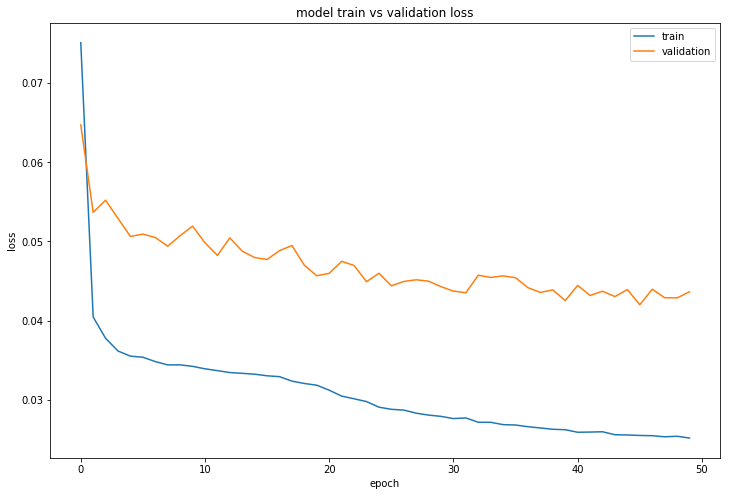

In [579]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
test = 0 # test is useless for this version where we only do validation
pred1, pred2, lstm_1 = s2s_a.run_model(X_train, X_train_demo, Y_train_1, Y_train_2, test, train_ls, 
                                     demo_ls, n_input, n_out, epochs = 50, batch_size = 32)

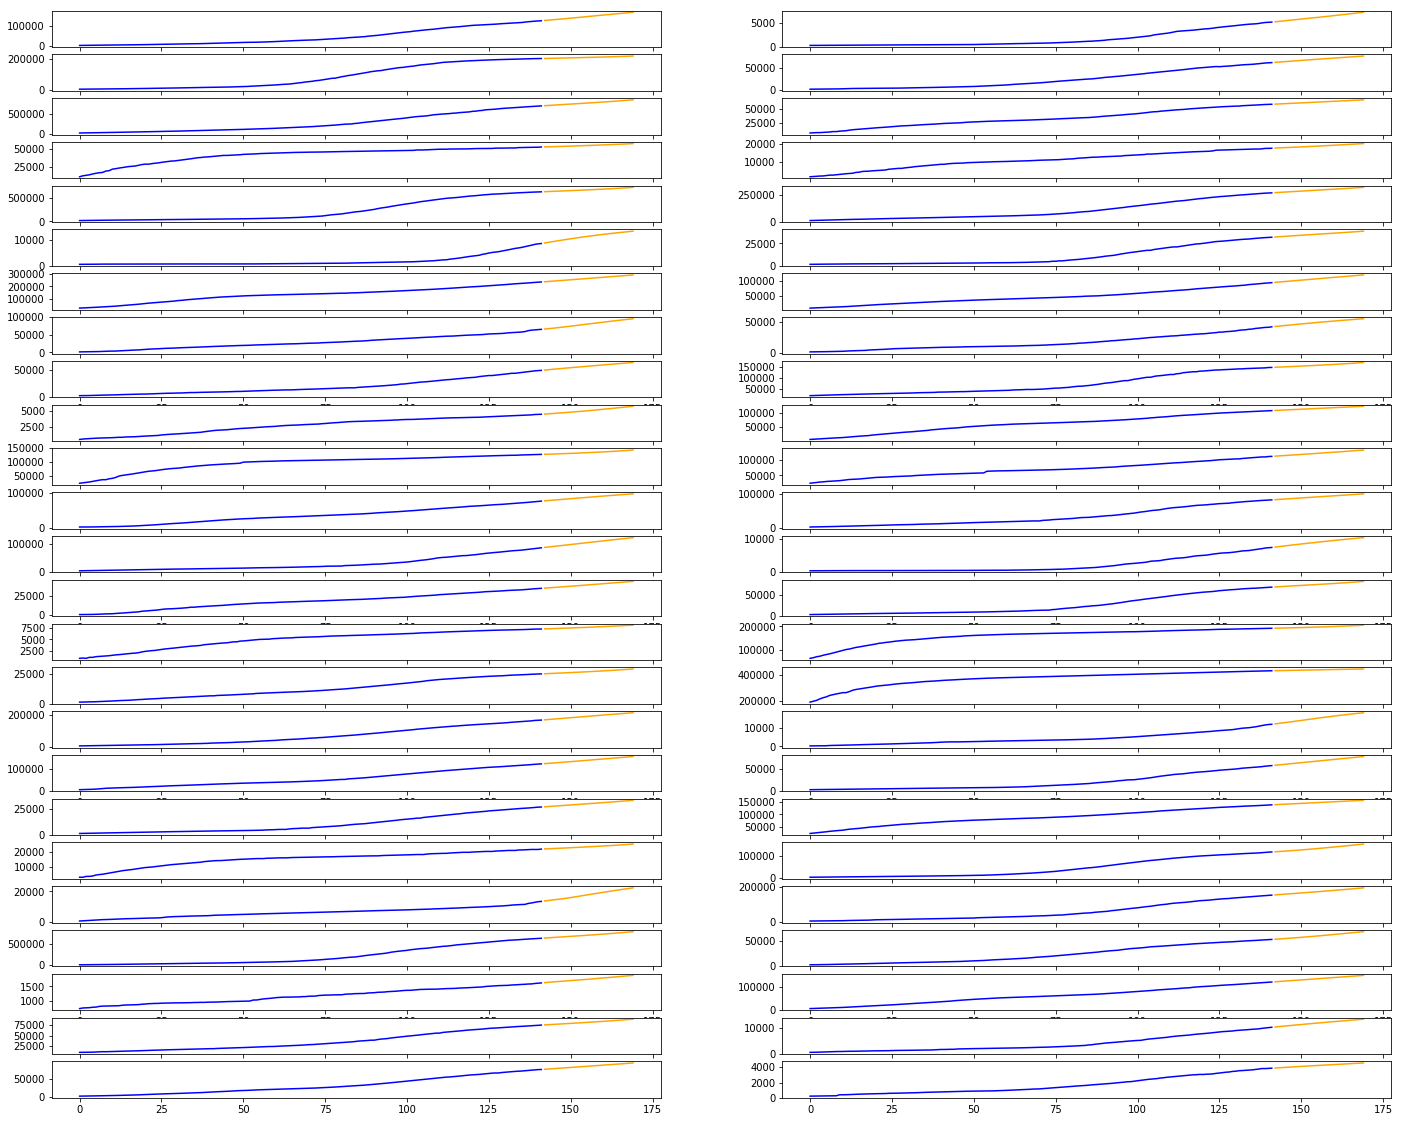

In [580]:
matplotlib.rcParams['figure.figsize'] = (24.0, 20.0)
fig, ax = plt.subplots(25, 2)
pp1 = []
for i in range(len(pred1)):
    p = np.unique(df_1['Province_State'])[i]
    start_val = df.loc[df.index == datetime.datetime.strptime('2020-08-31','%Y-%m-%d'), ].values[i][3]
    pred_list = np.array(pred1[i]).flatten()
    pred_list = scaler_1_each[i].inverse_transform(pred_list.reshape(-1, 1)).flatten().tolist()
    pred_list = [start_val] + pred_list
    pred_sum = np.cumsum(pred_list)[1:]
    #actual_list = np.diff(df[df['Province_State']==p]['Confirmed'].values)[-28:].tolist()
    #actual_list = np.diff(df[df['Province_State']==p]['Deaths'].values)[-28:].tolist()
    #actual_list = [start_val] + actual_list
    #actual_sum = np.cumsum(actual_list)
    actual_before = df[df['Province_State']==p]['Confirmed'].values
    days_before = len(actual_before)
    ax[int(i/2)][i%2].plot(np.arange(0,days_before), actual_before, color= 'blue')
    ax[int(i/2)][i%2].plot(np.arange(days_before,days_before+28), pred_sum, color= 'orange')
    #ax[int(i/2)][i%2].plot(np.arange(0,28), actual_sum, color = 'orange')
    #aa.append(actual_sum.tolist())
    pp1.append(pred_sum.tolist())

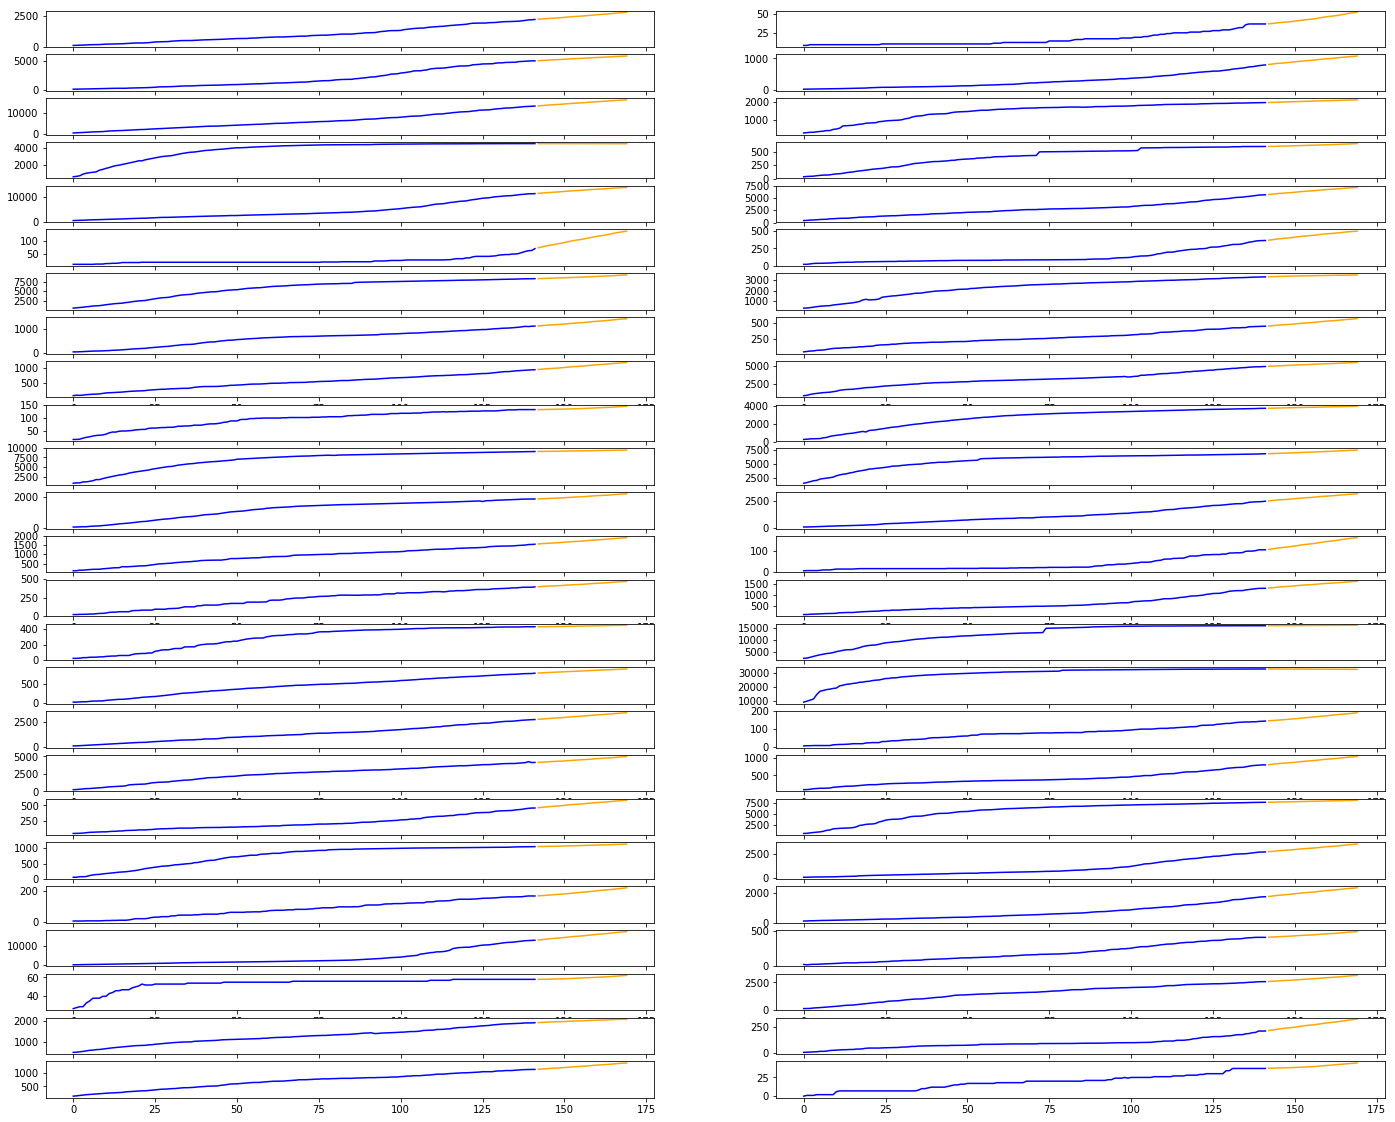

In [581]:
matplotlib.rcParams['figure.figsize'] = (24.0, 20.0)
fig, ax = plt.subplots(25, 2)
pp2 = []
for i in range(len(pred1)):
    p = np.unique(df_1['Province_State'])[i]
    start_val = df.loc[df.index == datetime.datetime.strptime('2020-08-31','%Y-%m-%d'), ].values[i][4]
    pred_list = np.array(pred2[i]).flatten()
    pred_list = scaler_2_each[i].inverse_transform(pred_list.reshape(-1, 1)).flatten().tolist()
    pred_list = [start_val] + pred_list
    pred_sum = np.cumsum(pred_list)[1:]
    #actual_list = np.diff(df[df['Province_State']==p]['Confirmed'].values)[-28:].tolist()
    #actual_list = np.diff(df[df['Province_State']==p]['Deaths'].values)[-28:].tolist()
    #actual_list = [start_val] + actual_list
    #actual_sum = np.cumsum(actual_list)
    actual_before = df[df['Province_State']==p]['Deaths'].values
    days_before = len(actual_before)
    ax[int(i/2)][i%2].plot(np.arange(0,days_before), actual_before, color= 'blue')
    ax[int(i/2)][i%2].plot(np.arange(days_before,days_before+28), pred_sum, color= 'orange')
    #ax[int(i/2)][i%2].plot(np.arange(0,28), actual_sum, color = 'orange')
    #aa.append(actual_sum.tolist())
    pp2.append(pred_sum.tolist())

#### Prepare output predicitions csv

In [557]:
submission = pd.read_csv("../data/submission.csv")
submission.head()

for i in range(26):
    for j in range(50):
        submission.iloc[i*50+j, 1] = pp1[j][i]
        submission.iloc[i*50+j, 2] = pp2[j][i]

In [559]:
submission.to_csv('Team15.csv', index = False)

#### (Bonus) Ensemble best outputs

In [2]:
sub1 = pd.read_csv("result1")
sub2 = pd.read_csv("result2")
sub3 = pd.read_csv("result3")
sub_ensemble = (sub1 + sub2 + sub3)/3
sub_ensemble['ForecastID'] = sub_ensemble['ForecastID'].values.astype('int')

FileNotFoundError: [Errno 2] File result1 does not exist: 'result1'

In [544]:
sub.to_csv('Team15.csv', index = False)